# Prediction from densenet embeddings

Input: 
- csv with disease labels + embeddings extracted using the densenet torch x ray vision model  

Do:  
- train a neural network multiclass classifier to predict the diseases  
- assess bias  

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR



### Read the CSV

In [ ]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

# test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(train_initial.columns)
train_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [3]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [4]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [5]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

### Remove columns

In [6]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [7]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = test.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 0


### Convert age to binary to study bias

In [8]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Create artificial training distribution

In [9]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

print("\nInitial Age Distribution:")
print(train['age'].value_counts())

print("\nInitial Health Distribution:")
print(train['insurance_type'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Initial Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Initial Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


In [ ]:
nb_of_rows_to_remove = 10000
cath_to_remove = 'sex' # sex or race
which_cath = 0 # 0 or 1 or 2

filtered_df = train[train[cath_to_remove] == which_cath]

rows_to_drop = filtered_df.sample(n=nb_of_rows_to_remove, random_state=42) 

train = train.drop(rows_to_drop.index)



Final sex Distribution:
sex
0    28279
1    20917
Name: count, dtype: int64

Final Race Distribution:
race
0    38970
1     7130
2     3096
Name: count, dtype: int64

Final Age Distribution:
age
1    24929
0    24267
Name: count, dtype: int64

Final Health Distribution:
insurance_type
1    34698
2    11040
0     3458
Name: count, dtype: int64


In [ ]:
nb_of_rows_to_add = 10000  # Number of rows to add
cath_to_add = 'sex'  # Could be 'sex' or 'race'
which_cath = 1  # 0, 1, or 2

# Filter to get a subset of the DataFrame based on a category
filtered_df = train[train[cath_to_add] == which_cath]

# Sample the rows you want to add (with replacement to allow duplicating rows)
rows_to_add = filtered_df.sample(n=nb_of_rows_to_add, replace=True, random_state=42)

# Append these rows to the original DataFrame
train = pd.concat([train, rows_to_add]).reset_index(drop=True)




Final sex Distribution:
sex
1    30917
0    28279
Name: count, dtype: int64

Final Race Distribution:
race
0    46680
1     8698
2     3818
Name: count, dtype: int64

Final Age Distribution:
age
1    30316
0    28880
Name: count, dtype: int64

Final Health Distribution:
insurance_type
1    41951
2    13044
0     4201
Name: count, dtype: int64


In [ ]:
print("\nFinal sex Distribution:")
print(train['sex'].value_counts())

print("\nFinal Race Distribution:")
print(train['race'].value_counts())

print("\nFinal Age Distribution:")
print(train['age'].value_counts())

print("\nFinal Health Distribution:")
print(train['insurance_type'].value_counts())

### Train evaluate test

In [12]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

In [13]:
# Diseases to predict
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

In [14]:
# learning_rate = 0.001
# weight_decay = 1e-1
# dropout = 0.2
# batch_size = 256

learning_rate = 0.001
weight_decay = 0
dropout = 0.5
batch_size = 256

In [15]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


In [16]:

# Assuming y_train is a tensor of shape (num_samples, num_classes)
# where each element is 0 or 1 indicating the absence or presence of a class

def calculate_sample_weights(y_train):
    # Calculate the frequency of each class
    class_counts = y_train.sum(axis=0)
    print(class_counts)
    # Compute the weight for each class (inverse frequency, normalized)
    class_weights = 1. / (class_counts + 1e-5)  # Add a small value to avoid division by zero
    class_weights /= class_weights.sum()  # Normalize so that sum of weights is 1
    print(class_weights)
    
    # Compute the sample weights
    sample_weights = torch.mm(y_train, class_weights.unsqueeze(1)).squeeze()
    
    return sample_weights

sample_weights = calculate_sample_weights(y_train)

# Convert sample weights to a Sampler compatible format
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create DataLoader using the WeightedRandomSampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)


tensor([ 7633., 29896., 14719.,  8898.,  5305., 24138.], device='cuda:0')
tensor([0.2280, 0.0582, 0.1182, 0.1955, 0.3280, 0.0721], device='cuda:0')


In [17]:

# Define a more complex neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(MultiLabelNN, self).__init__()
        # Increase the complexity by adding more layers and a wider network
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(128, output_size)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [18]:
# Calculate weights inversely proportional to class frequencies
class_counts = y_train.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.mean()  # Normalizing


# Example to increase the weight of positive examples in loss calculation
pos_weights = torch.ones([len(diseases)]).to(device)  # one weight per class
pos_weights *= 5  # Increasing the weights for positive examples

# Use these weights in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


In [19]:
model = MultiLabelNN(1024, len(diseases), dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [20]:
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=1) 

In [21]:


def train_model(train_loader, validation_loader, model, criterion, optimizer, scheduler, num_epochs):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        training_stats['val_loss'].append(total_val_loss / len(validation_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        # Update the learning rate
        scheduler.step()


    return training_stats


Epoch 1/6, Training Loss: 0.5398, Validation Loss: 0.4610
Epoch 2/6, Training Loss: 0.5216, Validation Loss: 0.4521
Epoch 3/6, Training Loss: 0.5163, Validation Loss: 0.4402
Epoch 4/6, Training Loss: 0.5107, Validation Loss: 0.4387
Epoch 5/6, Training Loss: 0.5060, Validation Loss: 0.4464
Epoch 6/6, Training Loss: 0.5049, Validation Loss: 0.4437


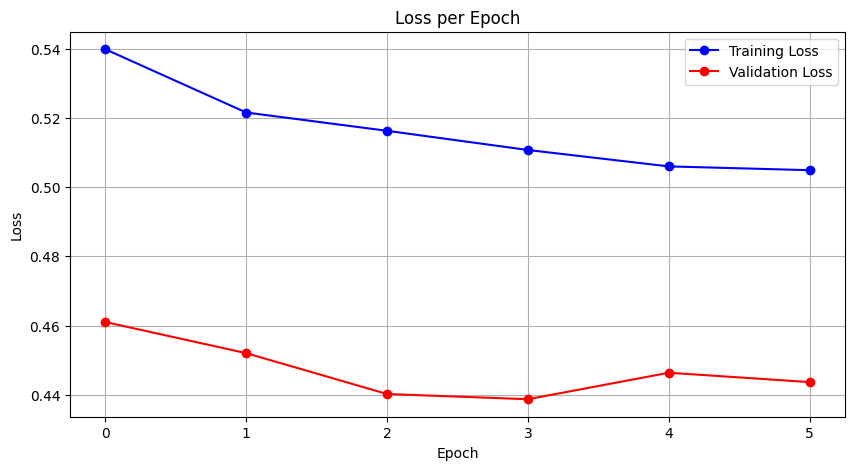

In [22]:
# Run training
nb_epoch = 6
stats = train_model(train_loader, valid_loader, model, criterion, optimizer, scheduler, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

In [24]:
# Evaluate on test data
predictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



In [25]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']



In [26]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.7975289651921502, 'AUC': 0.8079466067750423, 'AUPRC': 0.40890460682655916, 'F1 Score': 0.43542026980283643, 'TP Rate': 0.634475806451613, 'FN Rate': 0.3655241935483871, 'TN Rate': 0.8204090870512349, 'FP Rate': 0.1795909129487651}, 'Lung Opacity': {'Accuracy': 0.5124420075917334, 'AUC': 0.6889420271451634, 'AUPRC': 0.6376718440636171, 'F1 Score': 0.032397833579517483, 'TP Rate': 0.016579318685748842, 'FN Rate': 0.9834206813142512, 'TN Rate': 0.9933049894932316, 'FP Rate': 0.0066950105067683134}, 'Edema': {'Accuracy': 0.7723472349715931, 'AUC': 0.7871489102199662, 'AUPRC': 0.49881750822779525, 'F1 Score': 0.45289768662055807, 'TP Rate': 0.3921528136293237, 'FN Rate': 0.6078471863706763, 'TN Rate': 0.8925935601854875, 'FP Rate': 0.10740643981451244}, 'Atelectasis': {'Accuracy': 0.8249435581908849, 'AUC': 0.6008203050740696, 'AUPRC': 0.20498754338614011, 'F1 Score': 0.11733800350262695, 'TP Rate': 0.07564516129032257, 'FN Rate': 0.9243548387096774, 'TN Rate

### Compute metrics for different categories

In [27]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [28]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,40.890,80.795,81.190,80.193,0.997,1.031
1,Lung Opacity,63.767,68.894,68.850,68.948,0.098,0.185
2,Edema,49.882,78.715,78.887,78.485,0.402,2.348
3,Atelectasis,20.499,60.082,60.956,58.744,2.212,0.494
4,Pneumothorax,26.381,73.072,72.507,73.824,1.317,1.398
5,Pleural Effusion,71.272,81.574,81.331,81.949,0.618,3.912


In [29]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,40.890,80.795,80.238,81.933,81.354,1.694,9.084
1,Lung Opacity,63.767,68.894,68.462,70.960,70.029,2.498,0.671
2,Edema,49.882,78.715,78.698,77.344,79.604,2.261,2.912
3,Atelectasis,20.499,60.082,60.333,56.777,59.402,3.556,2.632
4,Pneumothorax,26.381,73.072,72.502,74.787,74.790,2.289,7.180
5,Pleural Effusion,71.272,81.574,81.388,80.953,82.642,1.689,3.804


In [30]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,40.890,80.795,77.541,82.263,4.721,5.427
1,Lung Opacity,63.767,68.894,65.173,70.633,5.460,0.085
2,Edema,49.882,78.715,76.746,79.603,2.858,2.164
3,Atelectasis,20.499,60.082,58.370,61.044,2.674,0.914
4,Pneumothorax,26.381,73.072,74.128,71.941,2.187,7.463
5,Pleural Effusion,71.272,81.574,81.243,81.679,0.437,4.031


In [31]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,40.890,80.795,82.686,79.886,81.272,2.800,8.262
1,Lung Opacity,63.767,68.894,71.255,66.926,71.935,5.009,0.410
2,Edema,49.882,78.715,77.304,77.679,80.999,3.696,2.427
3,Atelectasis,20.499,60.082,60.338,59.442,61.449,2.007,1.877
4,Pneumothorax,26.381,73.072,72.573,73.371,71.199,2.172,10.151
5,Pleural Effusion,71.272,81.574,82.030,81.009,82.403,1.395,4.322


In [32]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,40.890,80.795,0.997,1.031,1.694,9.084,4.721,5.427,2.800,8.262
1,Lung Opacity,63.767,68.894,0.098,0.185,2.498,0.671,5.460,0.085,5.009,0.410
2,Edema,49.882,78.715,0.402,2.348,2.261,2.912,2.858,2.164,3.696,2.427
3,Atelectasis,20.499,60.082,2.212,0.494,3.556,2.632,2.674,0.914,2.007,1.877
4,Pneumothorax,26.381,73.072,1.317,1.398,2.289,7.180,2.187,7.463,2.172,10.151
5,Pleural Effusion,71.272,81.574,0.618,3.912,1.689,3.804,0.437,4.031,1.395,4.322


### Study a specific metric and compare

In [33]:
met = 'AUPRC'  #Accuracy, AUC, F1 Score, TP Rate, FN Rate

In [34]:
# Compute metrics for each disease
auc_general = {}
for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == met:
            auc_general[disease] = value

print(f"General {met}", auc_general)


General AUPRC {'Cardiomegaly': 0.40890460682655916, 'Lung Opacity': 0.6376718440636171, 'Edema': 0.49881750822779525, 'Atelectasis': 0.20498754338614011, 'Pneumothorax': 0.26381292643562915, 'Pleural Effusion': 0.7127231464362184}


In [35]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

for disease, values in metrics_female.items():
    for metric, value in values.items():
        if metric == met:
            auc_female[disease] = value

for disease, values in metrics_male.items():
    for metric, value in values.items():
        if metric == met:
            auc_male[disease] = value

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


AUPRC for Females: {'Cardiomegaly': 0.3799762364244616, 'Lung Opacity': 0.6377093960365263, 'Edema': 0.5082405492015953, 'Atelectasis': 0.18802655645391791, 'Pneumothorax': 0.25873646603366623, 'Pleural Effusion': 0.7187013343983087}
AUPRC for Males: {'Cardiomegaly': 0.42857322730199693, 'Lung Opacity': 0.6376943338796398, 'Edema': 0.4918632054551948, 'Atelectasis': 0.21817175602022465, 'Pneumothorax': 0.2674594624815442, 'Pleural Effusion': 0.7087357831884125}


In [36]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

for disease, values in metrics_white.items():
    for metric, value in values.items():
        if metric == met:
            auc_white[disease] = value

for disease, values in metrics_asian.items():
    for metric, value in values.items():
        if metric == met:
            auc_asian[disease] = value

for disease, values in metrics_black.items():
    for metric, value in values.items():
        if metric == met:
            auc_black[disease] = value

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


AUPRC for W: {'Cardiomegaly': 0.3792441639240473, 'Lung Opacity': 0.6347391169291363, 'Edema': 0.5008242871872812, 'Atelectasis': 0.2114958281248617, 'Pneumothorax': 0.2555581446760277, 'Pleural Effusion': 0.7134218235764413}
AUPRC for B: {'Cardiomegaly': 0.554857906654975, 'Lung Opacity': 0.6437865429519075, 'Edema': 0.5309465493036952, 'Atelectasis': 0.16383966683157652, 'Pneumothorax': 0.21965189823610135, 'Pleural Effusion': 0.6419921397846264}
AUPRC for A: {'Cardiomegaly': 0.4458176093053105, 'Lung Opacity': 0.6498881753238874, 'Edema': 0.47181270505518835, 'Atelectasis': 0.18602634034638016, 'Pneumothorax': 0.3233790579921967, 'Pleural Effusion': 0.7359780171158631}


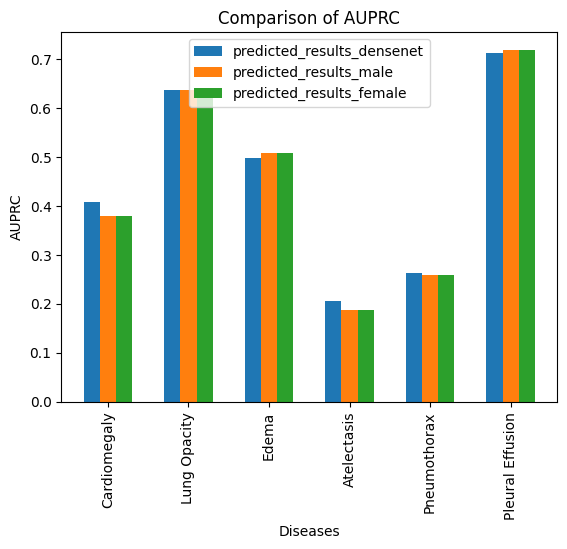

In [37]:

# Extract diseases and AUC values
diseases_to_plot = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases_to_plot]
values_male = [auc_female[disease] for disease in diseases_to_plot]
values_female = [auc_female[disease] for disease in diseases_to_plot]

# Setting the positions and width for the bars
positions = np.arange(len(diseases_to_plot))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


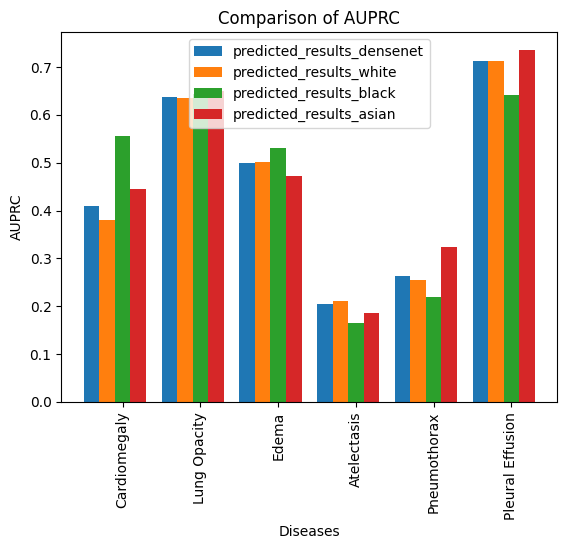

In [38]:

# Extract diseases and AUC values
diseases = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
